In [1]:
import numpy as np # linear algebra
import pandas as pd 
import time
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn.modules import linear
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import optim 
from collections import defaultdict
import pickle 
from matplotlib import pyplot as plt 
import time

In [2]:
cd /content/drive/MyDrive/DF

/content/drive/MyDrive/DF


In [130]:
class Lenet(nn.Module):
    def __init__(self, n_classes=10, dropout=0.2):
        super(Lenet, self).__init__()

        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) #28*28*6
        self.tanh = nn.Tanh()
        self.avg_pool = nn.AvgPool2d(kernel_size=2, padding=0) #14*14*6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) #10 * 10* 16
#             nn.Tanh(),
#             nn.AvgPool2d(kernel_size=2, padding=0), # 5*5*16
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5) #1*1*120
#             nn.Tanh(),
        self.linear = nn.Sequential(
            nn.Linear(120, 84),
            nn.LayerNorm(normalized_shape=84),
            nn.Tanh(),
            nn.Linear(84, n_classes),
            nn.Dropout(dropout)
        )
    
    def forward(self, images: Tensor):
        """
        input:
            images: batch_size * 3 *32 *32 
        
        outptu:
            tensor: batch_size * n_classes
        """
        data = []
        
        outs = self.conv1(images)
        data.append(outs)
        outs = self.avg_pool(self.tanh(outs))
        
        outs = self.conv2(outs)
        data.append(outs)
        outs = self.avg_pool(self.tanh(outs))
        
        outs = self.conv3(outs)
        data.append(outs)
        outs = self.tanh(outs)
        
        outs = outs.reshape(outs.size(0), -1)
        return self.linear(outs),data 


class Alexnet(nn.Module):
    def __init__(self, n_classes:int = 10,
                 dropout:float = 0.2,
        ):
        super(Alexnet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        self.relu = nn.ReLU(inplace=True)
        self.max_pool2d = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#                 nn.ReLU(inplace=True),
#                 nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
        self.conv3 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#                 nn.ReLU(inplace=True),
        self.conv4 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#                 nn.ReLU(inplace=True),
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#                 nn.ReLU(inplace=True),
#                 nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#             )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.linear = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.LayerNorm(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, images):
        data = []
            
        outs = self.conv1(images)
        data.append(outs)
        outs = self.max_pool2d(self.relu(outs))
            
        outs = self.conv2(outs)
        data.append(outs)
        outs = self.max_pool2d(self.relu(outs))
            
        outs = self.conv3(outs)
        data.append(outs)
        outs = self.relu(outs)
        
        outs = self.conv4(outs)
        data.append(outs)
        outs = self.relu(outs)
            
        outs = self.conv5(outs)
        data.append(outs)
        outs = self.relu(outs)
        
        outs = self.avgpool(outs)
        data.append(outs)
        outs = outs.reshape(outs.size(0), -1)
        return self.linear(self.dropout(outs)), data
        

        

In [131]:
class Trainer:
    def __init__(self, model_name: str,
                batch_size: int = 64,
                lr: float = 1e-5,
                path_save_model: str = "",
                n_epochs: int = 100,
                training_data_percent:float = 0.2
        ):
        self.model_name = model_name
        self.n_classes = 10
        self.batch_size = batch_size
        self.lr = lr 
        self.training_data_percent = training_data_percent
        self.path_save_model = path_save_model
        self.n_epochs = n_epochs 
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.get_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.acc_test_current = 0
        self.make_loader()
    
    def get_model(self):
        if self.model_name == "lenet":
            model = Lenet(n_classes=self.n_classes).to(self.device)
            self.input_size = 32

        elif self.model_name =="alexnet":
            model = Alexnet(n_classes=self.n_classes).to(self.device)
            self.input_size = 224
        else:
            raise Exception("Not implement")

        return model
    
    def make_loader(self):
        self.transform = transforms.Compose([
            transforms.Resize(self.input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.train_set = torchvision.datasets.CIFAR10(root='datasets/cifar10', 
                                            train=True, 
                                            download=True,
                                            transform=self.transform
                                        )
        self.test_set = torchvision.datasets.CIFAR10(root='datasets/cifar10',
                                        train=False,
                                        download=True,
                                        transform=self.transform
                                        )
        self.n_train_samples = int(self.training_data_percent * len(self.train_set))
        self.n_val_samples = len(self.train_set) - self.n_train_samples
        self.train_set, self.val_set = random_split(
            self.train_set,
            lengths=[self.n_train_samples, self.n_val_samples],
            generator=torch.Generator().manual_seed(42),
        )
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True,num_workers=2)
        self.val_loader = DataLoader(self.val_set, batch_size=self.batch_size, shuffle=True,num_workers=2)
        self.test_loader = DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2)


    def save_model(self, epoch):
        model_state ={
            "model" : self.model.state_dict(),
            "optimizer" : self.optimizer
        }
        torch.save(model_state, self.path_save_model+f'model{epoch}.pth')
        print("Save model done")
        with open(f"history{epoch}.pkl",'wb') as file:
            pickle.dump(self.history, file, protocol=pickle.HIGHEST_PROTOCOL)
        print("Save history done")
    
    def load_model(self,path_load):
        checkpoint = torch.load(path_load)
        self.model.load_state_dict(checkpoint['model'])

In [132]:
trainer = Trainer(
    model_name='alexnet',
    lr=8e-3,
    n_epochs=2,
    batch_size=256,
    training_data_percent=0.9
)

Files already downloaded and verified
Files already downloaded and verified


In [133]:
trainer.load_model('weights/model47.pth')

In [134]:
# trainer.n_epochs = 1

In [135]:
# trainer.fit()

In [136]:
trainset = 0

In [137]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [138]:
def transform(data):
  trans = transforms.Compose([
            transforms.Resize([32, 32])
        ])
  return trans(data)

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshowImage(data):
    img = data.detach().clone()
    for x in range(3):
        img[x] = img[x]*std[x] + mean[x]
    # img = transform(img) # resize (32,32)
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
def visual(trainer,index):
    trainer.model.eval()
    input_size = trainer.train_set[0][0].shape[1]
    with torch.no_grad():
        input = trainer.train_set[index][0]
        x = input.reshape(1,3,input_size,input_size)
        outs,data = trainer.model(x.to(device))
    return input,data

In [142]:
input,data_need = visual(trainer,0)

In [143]:
weights = trainer.model.state_dict()

In [144]:
trainer.model

Alexnet(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu): ReLU(inplace=True)
  (max_pool2d): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=4096, out_features=4096, bias=True)
    (6): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (7): ReLU(inplace=True)
    (8): Line

In [145]:
from matplotlib.pyplot import figure
def visualData(input,max = 64):
    f = (input - input.min())/(input.max()-input.min() + 1e-9 )

    figure(figsize=(18, 18), dpi=100)
    dim0 = f.shape[0]
    if dim0 > max:
        dim0 = max
    for i in range(dim0):
        image = f[i]
        plt.subplot(dim0/4+1,4,i+1)
        plt.imshow(image,cmap='gray')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

Visulization of layer 01

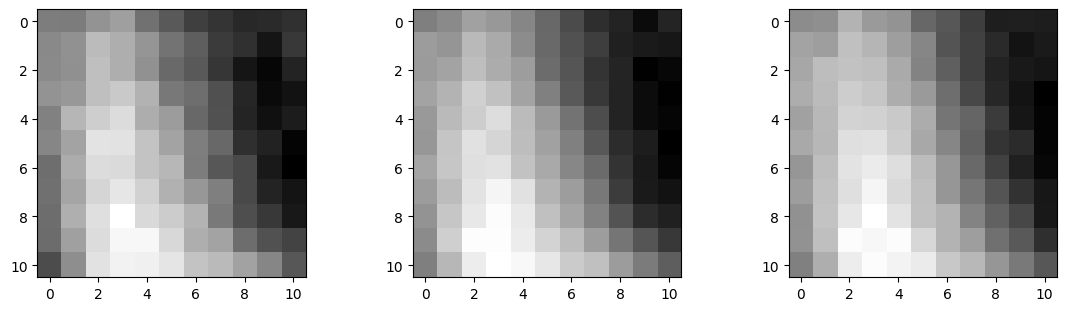

In [146]:
filterConv1 = weights['conv1.weight']
filterConv1 = np.array(filterConv1.cpu())
visualData(filterConv1[0]) # filter thứ 1 của conv1

Visulization of layer 02

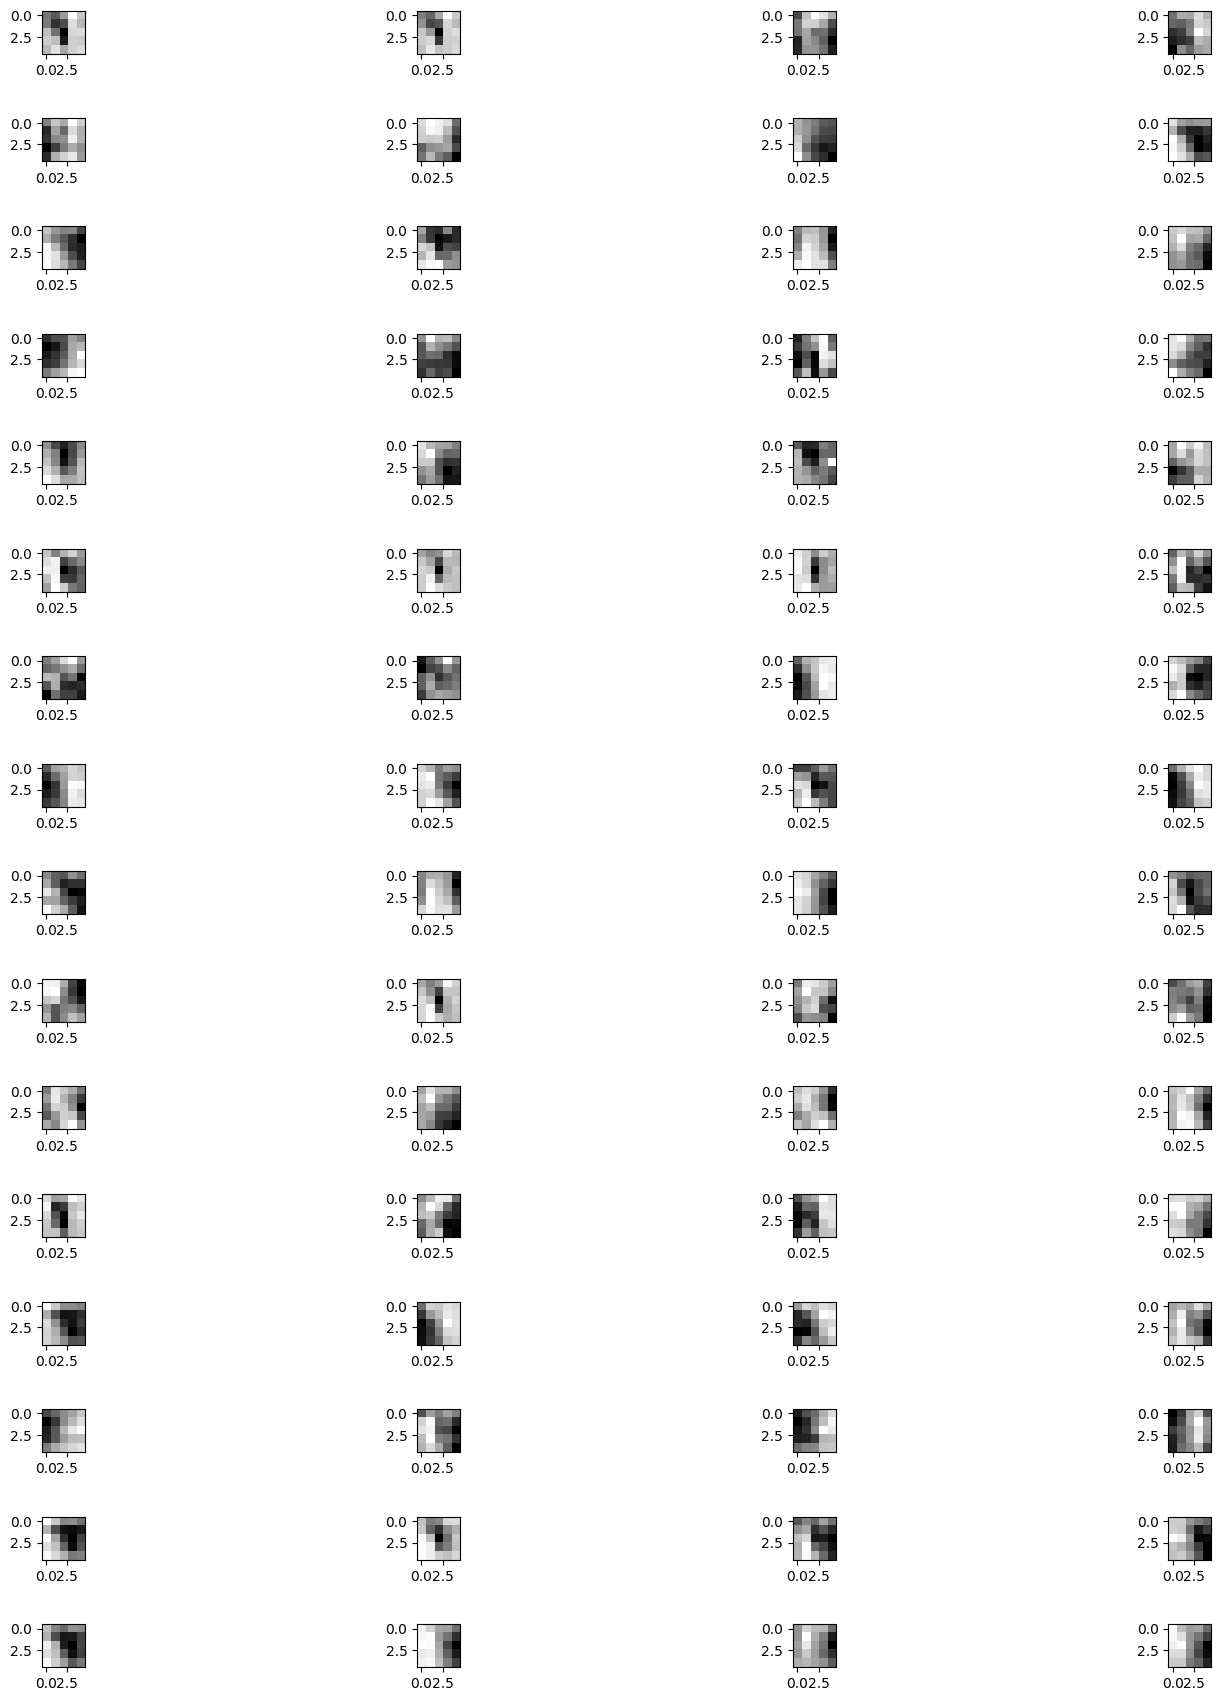

In [147]:
filterConv2 = weights['conv2.weight']
filterConv2 = np.array(filterConv2.cpu())
visualData(filterConv2[0]) # filter thứ 1 của conv2

Visulization of layer 03

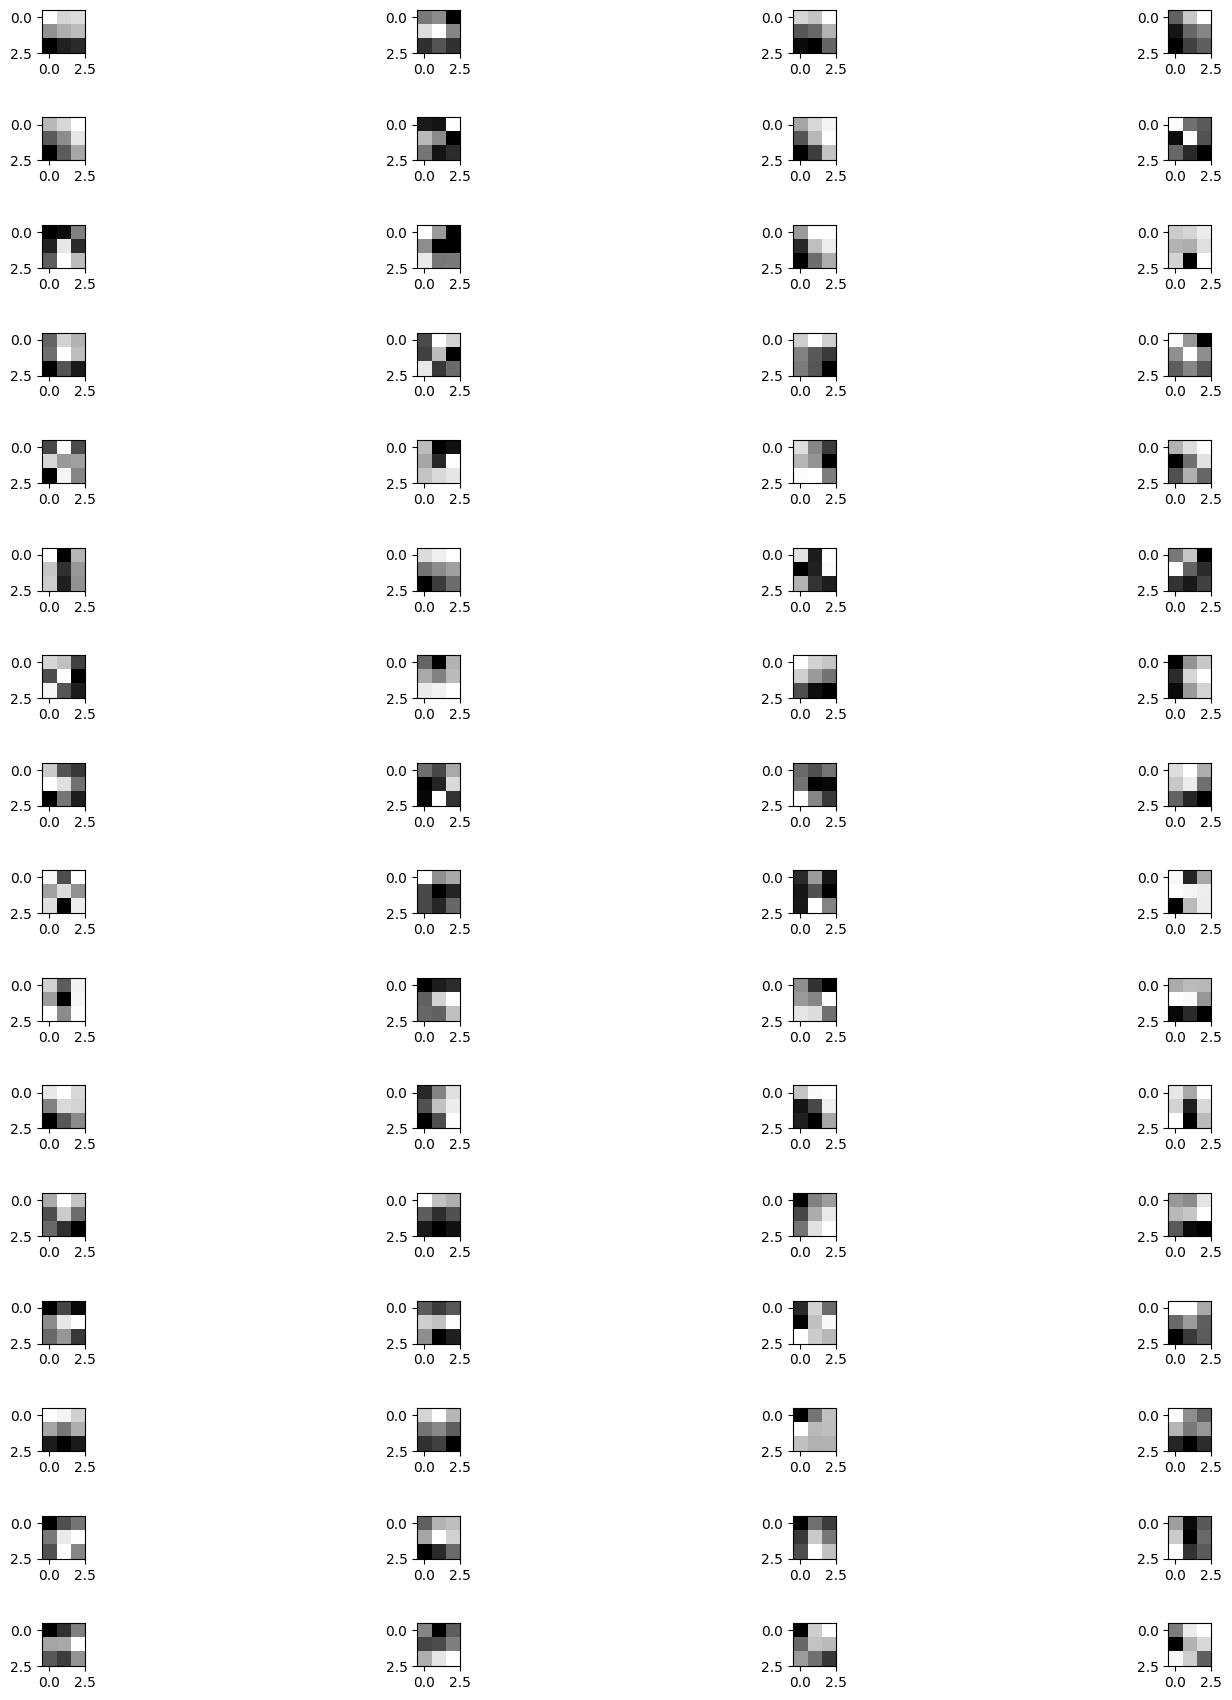

In [148]:
filterConv3 = weights['conv3.weight']
filterConv3 = np.array(filterConv3.cpu())
visualData(filterConv3[0]) # filter thứ 1 của conv3

Visulization of layer 04

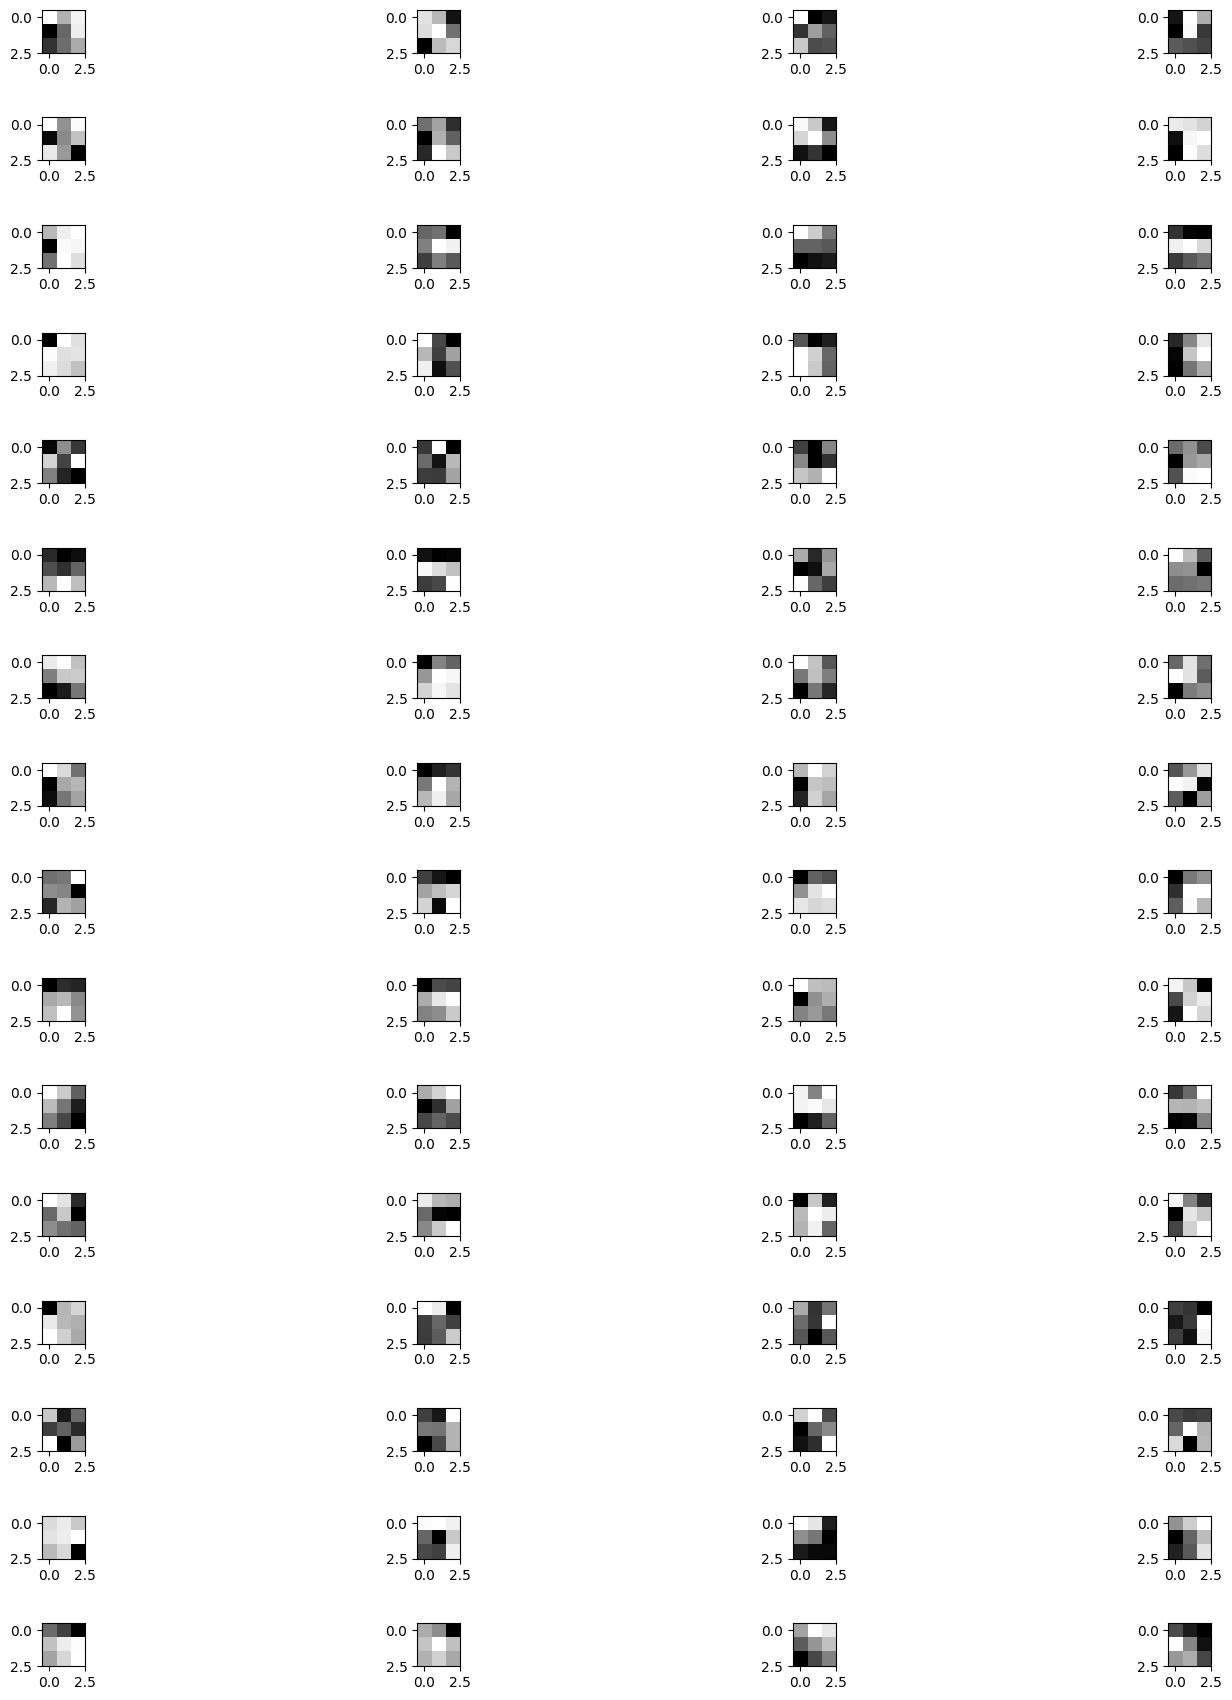

In [149]:
filterConv4 = weights['conv4.weight']
filterConv4 = np.array(filterConv4.cpu())
visualData(filterConv4[0]) # filter thứ 1 của conv4

Visulization of layer 05

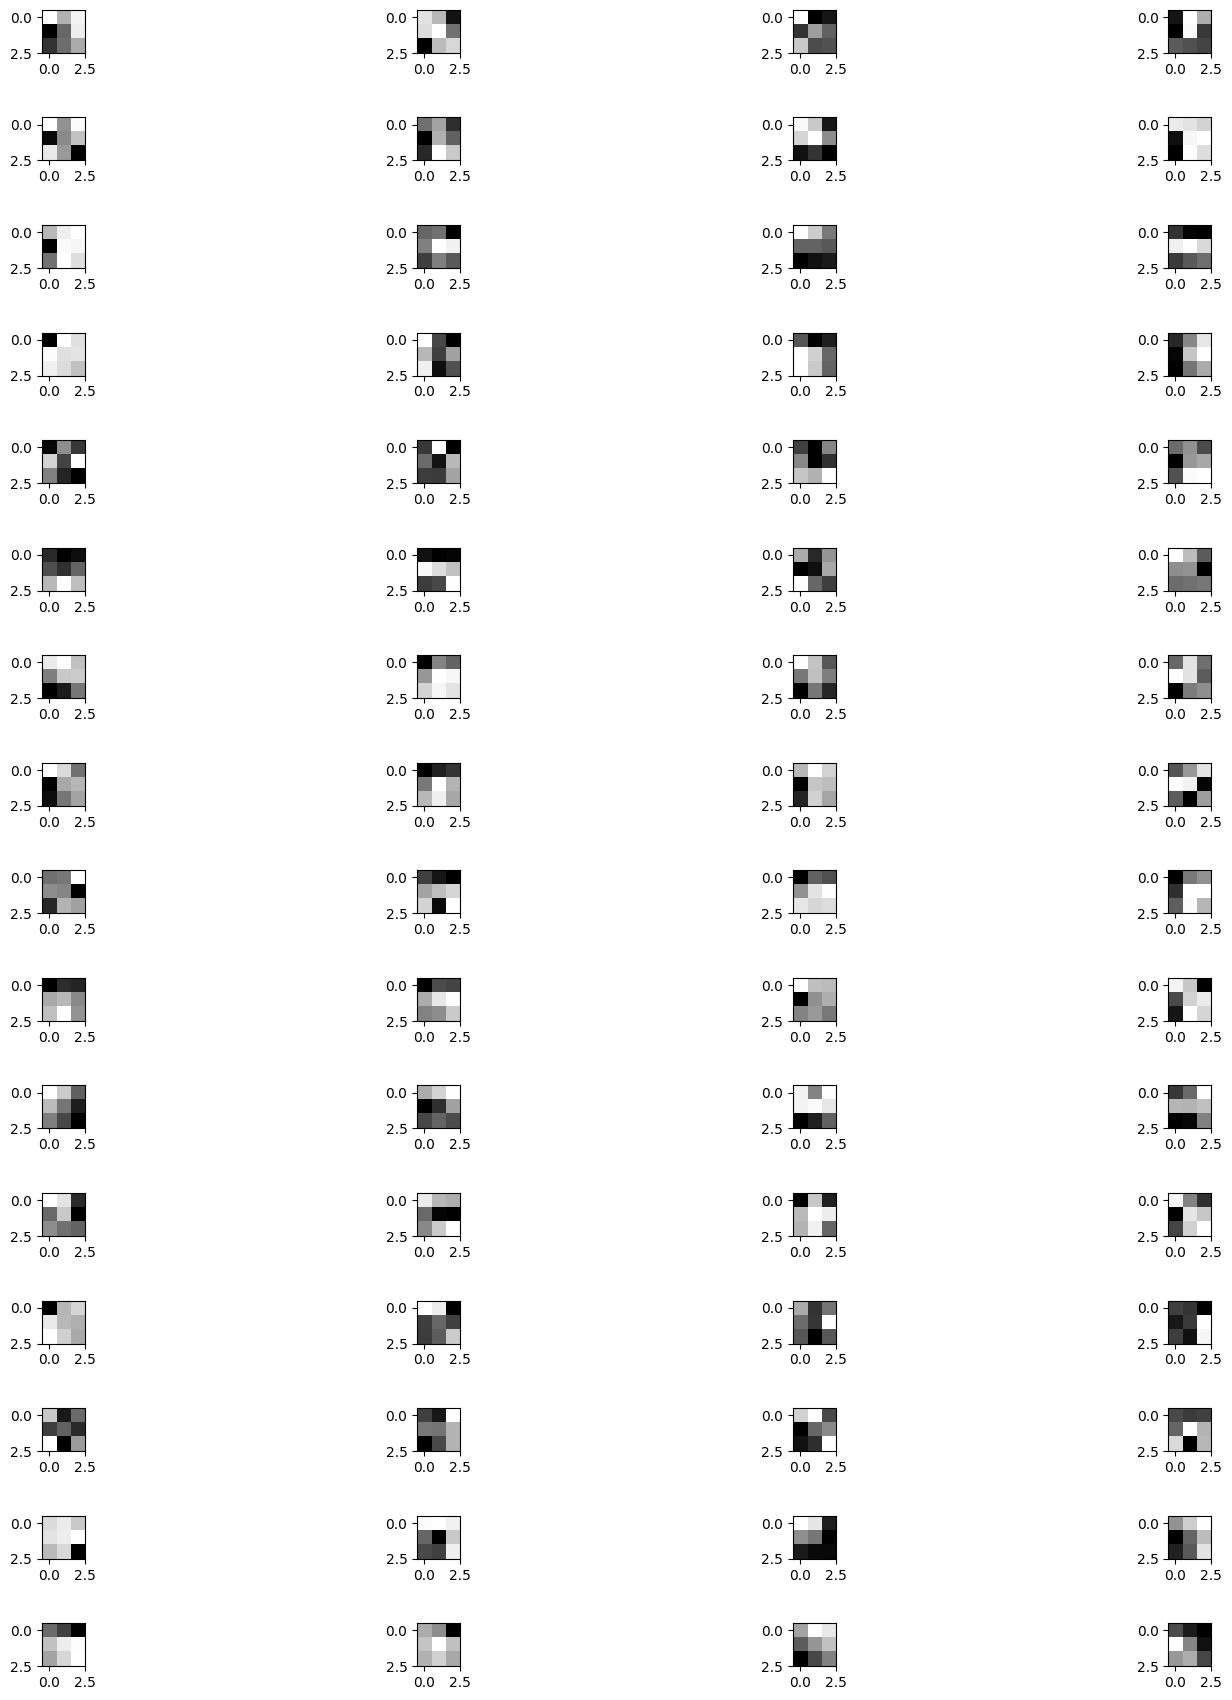

In [150]:
filterConv5 = weights['conv5.weight']
filterConv5 = np.array(filterConv5.cpu())
visualData(filterConv5[0]) # filter thứ 1 của conv5

Original Image

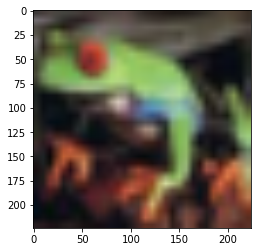

In [151]:
imshowImage(input)

In [152]:
dataVisual = [x.cpu() for x in data_need]

Layer 1: 64 Conv (11,11)

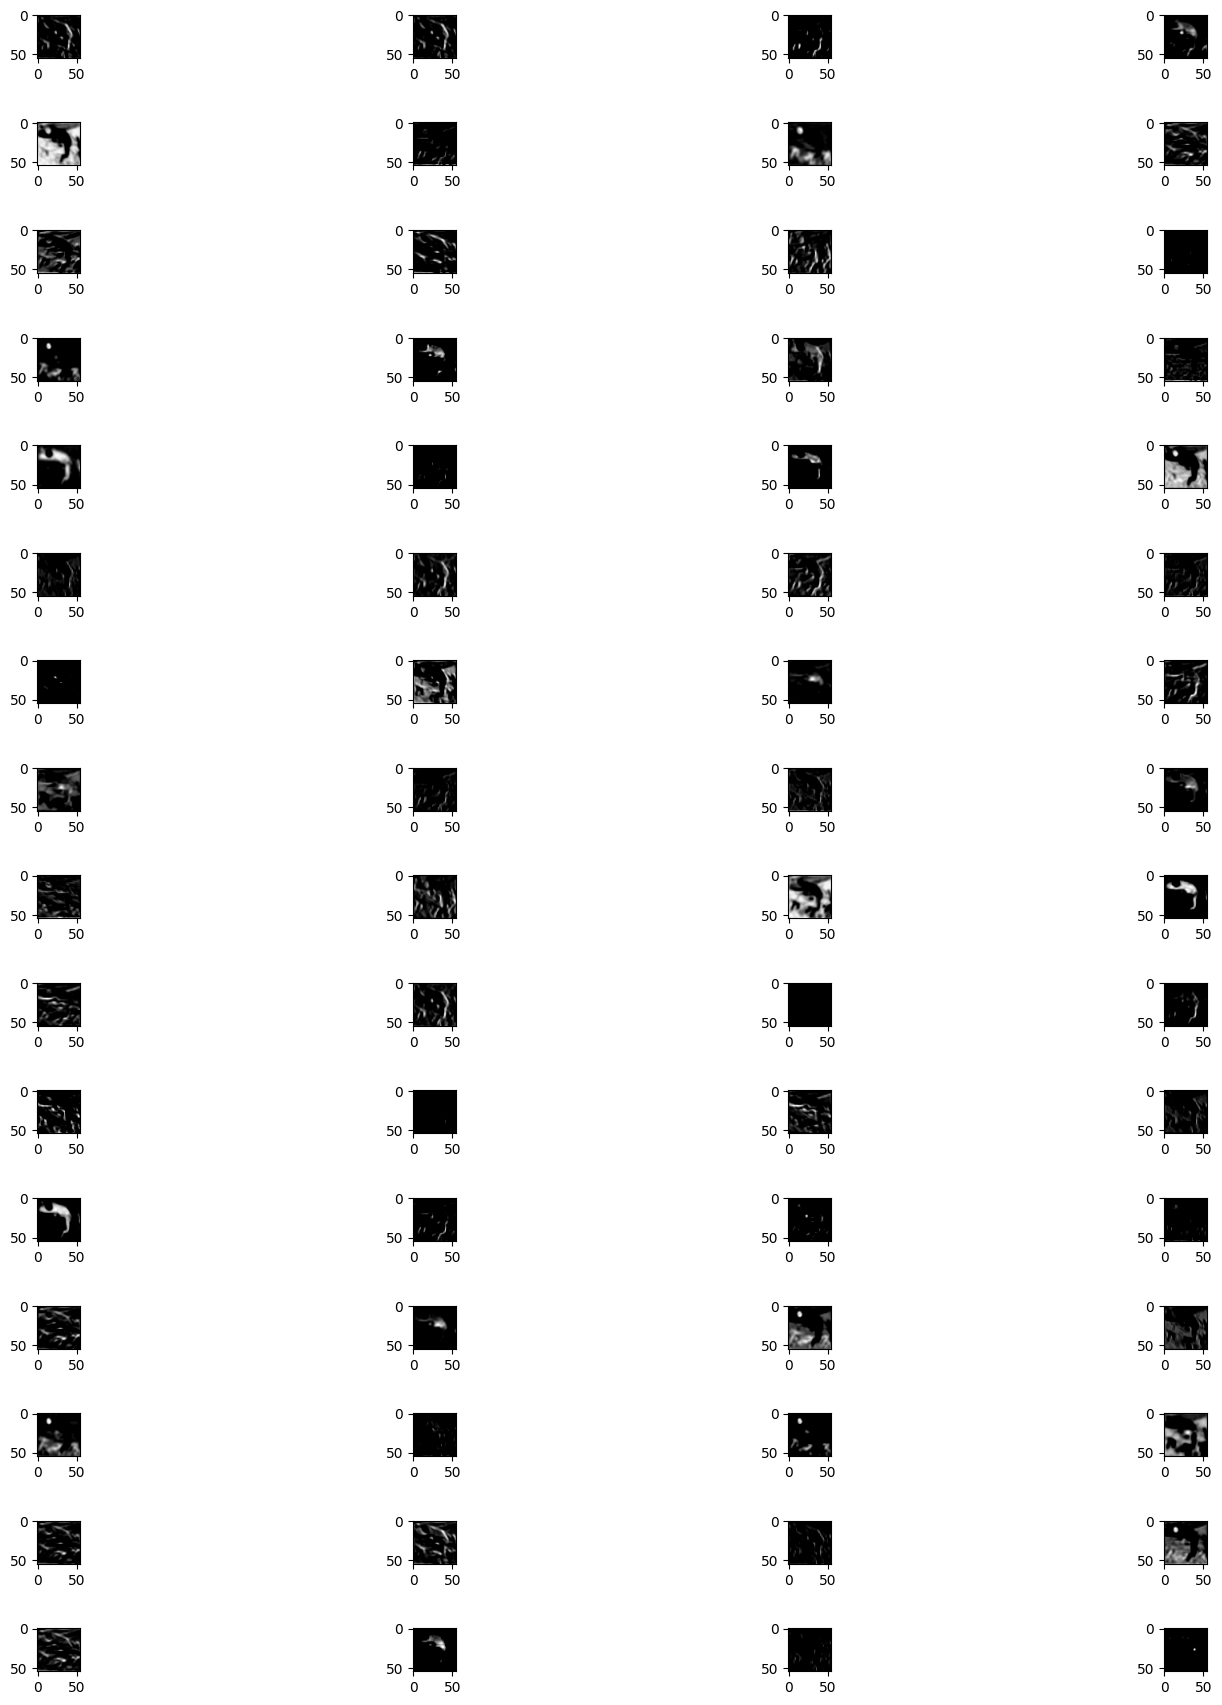

In [153]:
visualData(dataVisual[0][0])

Layer 2: 192 Conv (5,5)

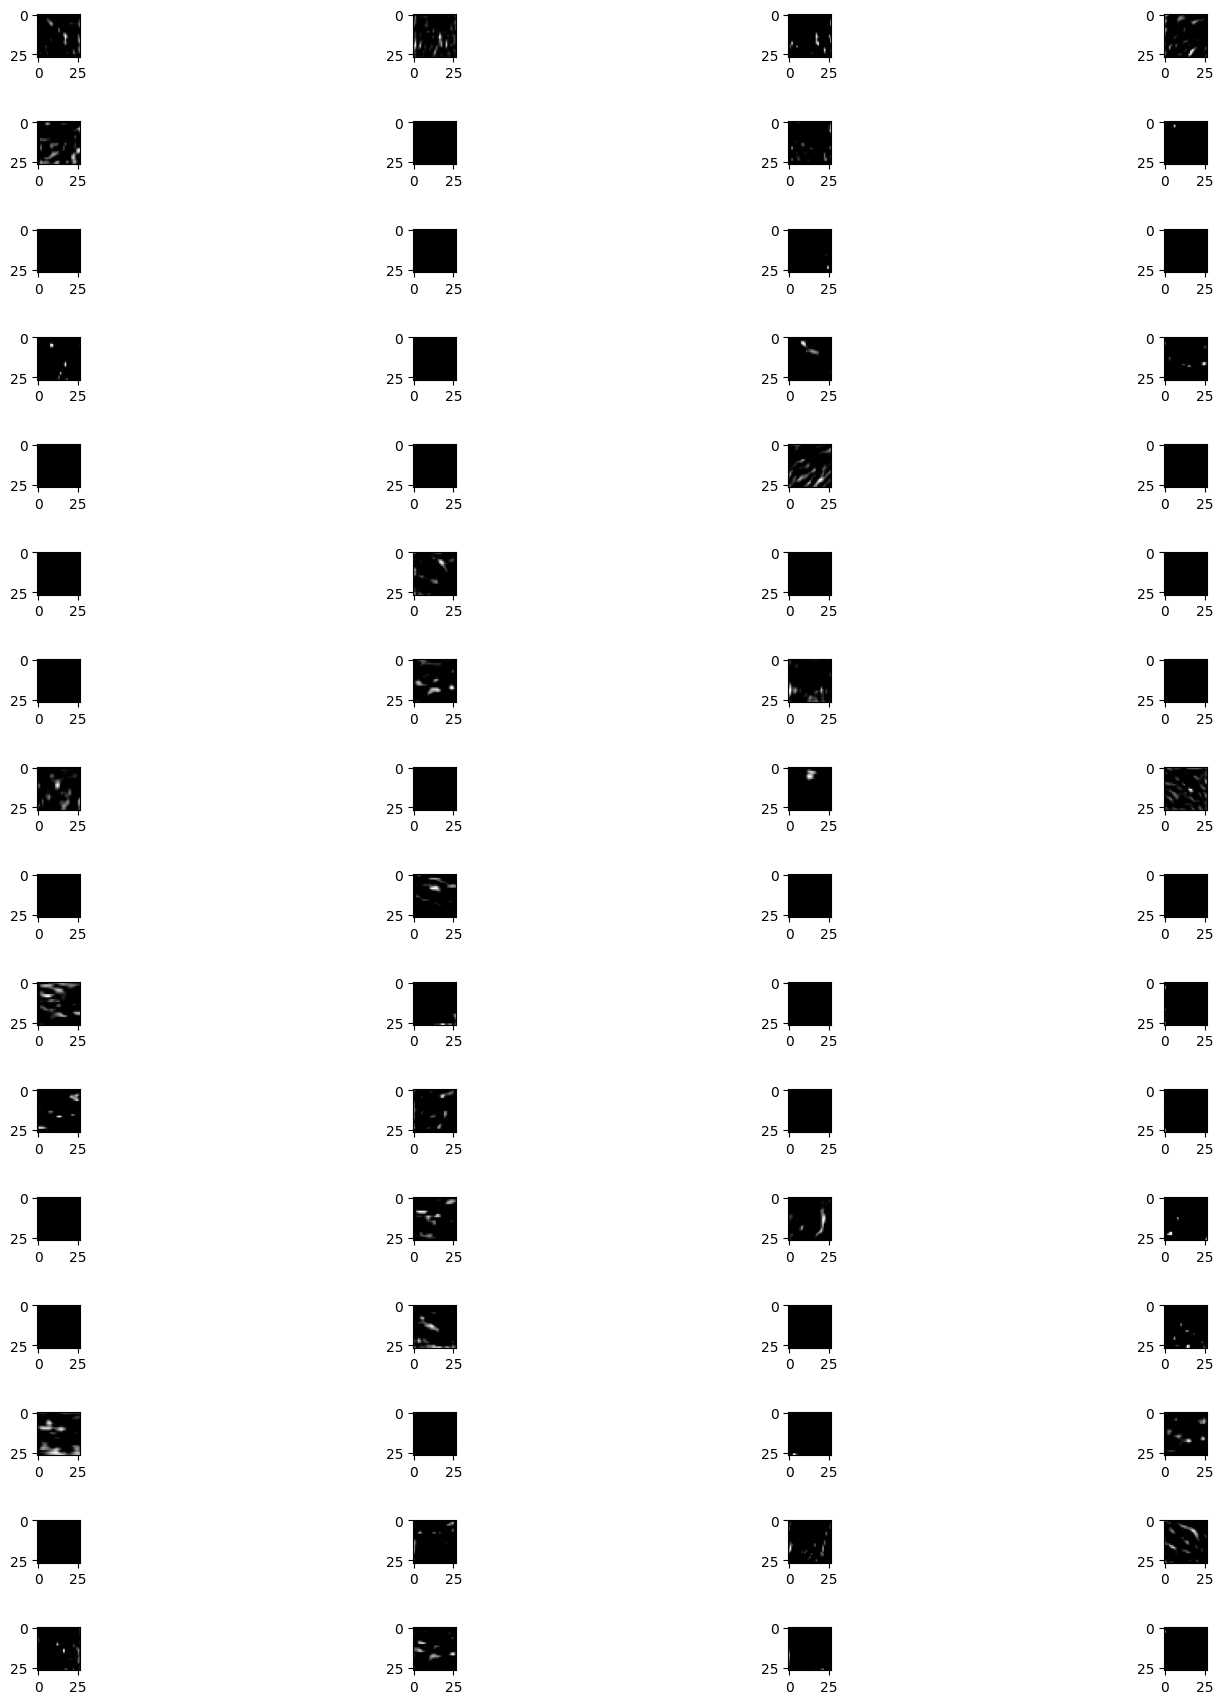

In [154]:
visualData(dataVisual[1][0])

Layer 3: 384 Conv (3,3)

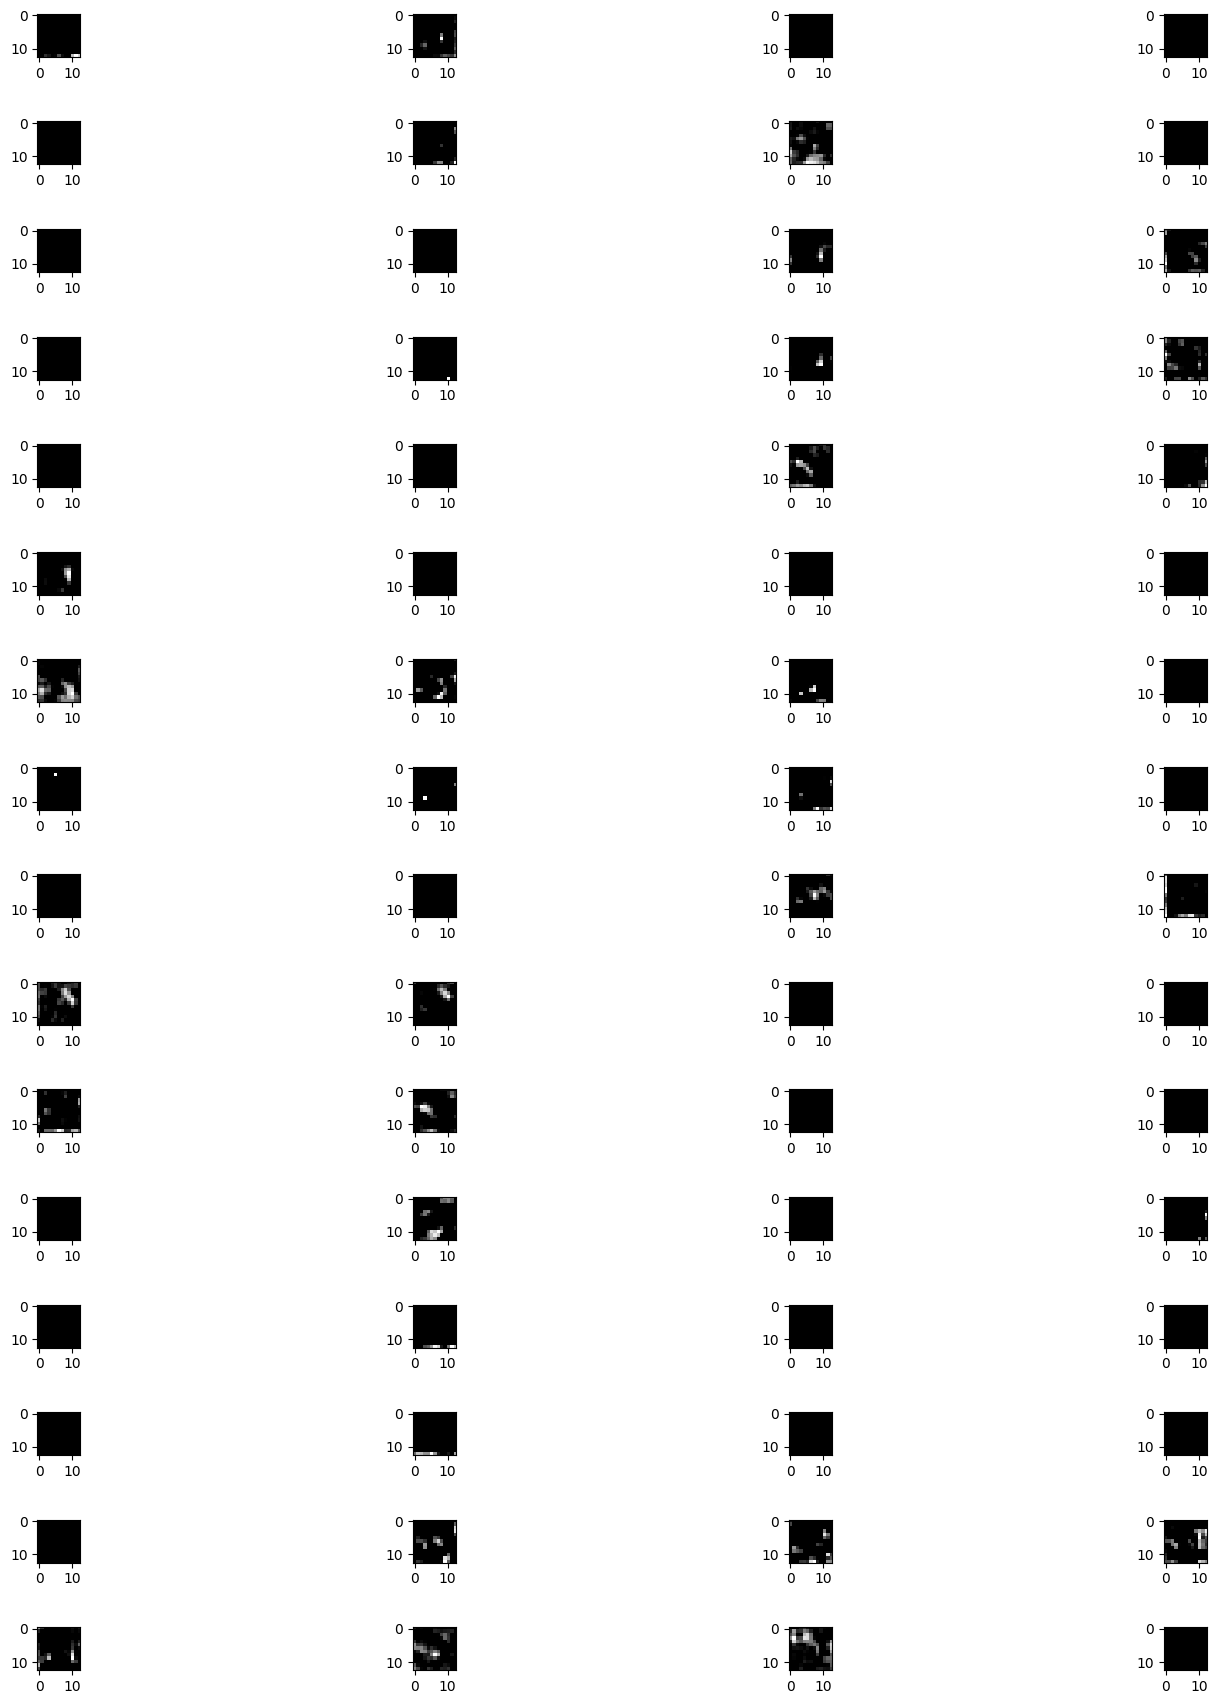

In [155]:
visualData(dataVisual[2][0])

Layer 4: 256 Conv (3,3)

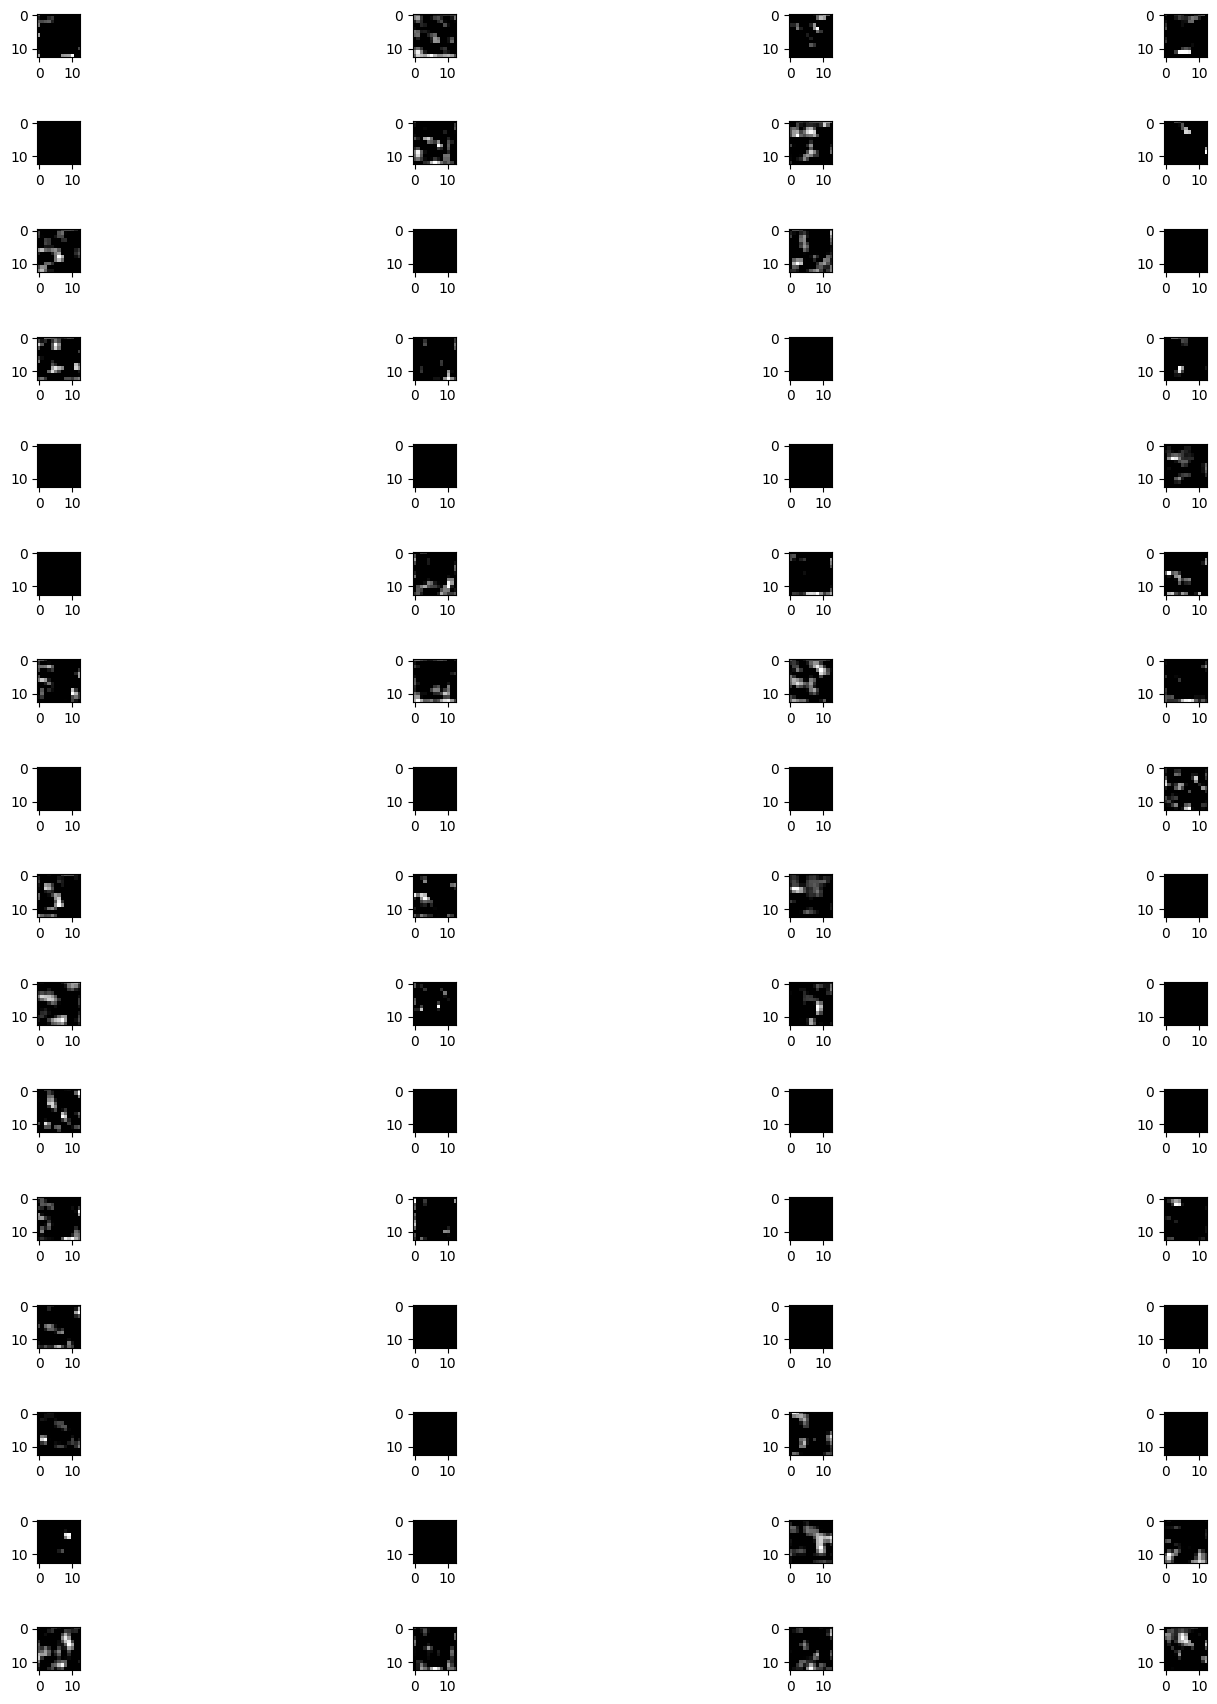

In [156]:
visualData(dataVisual[3][0])

Layer 5: 256 Conv (3,3)

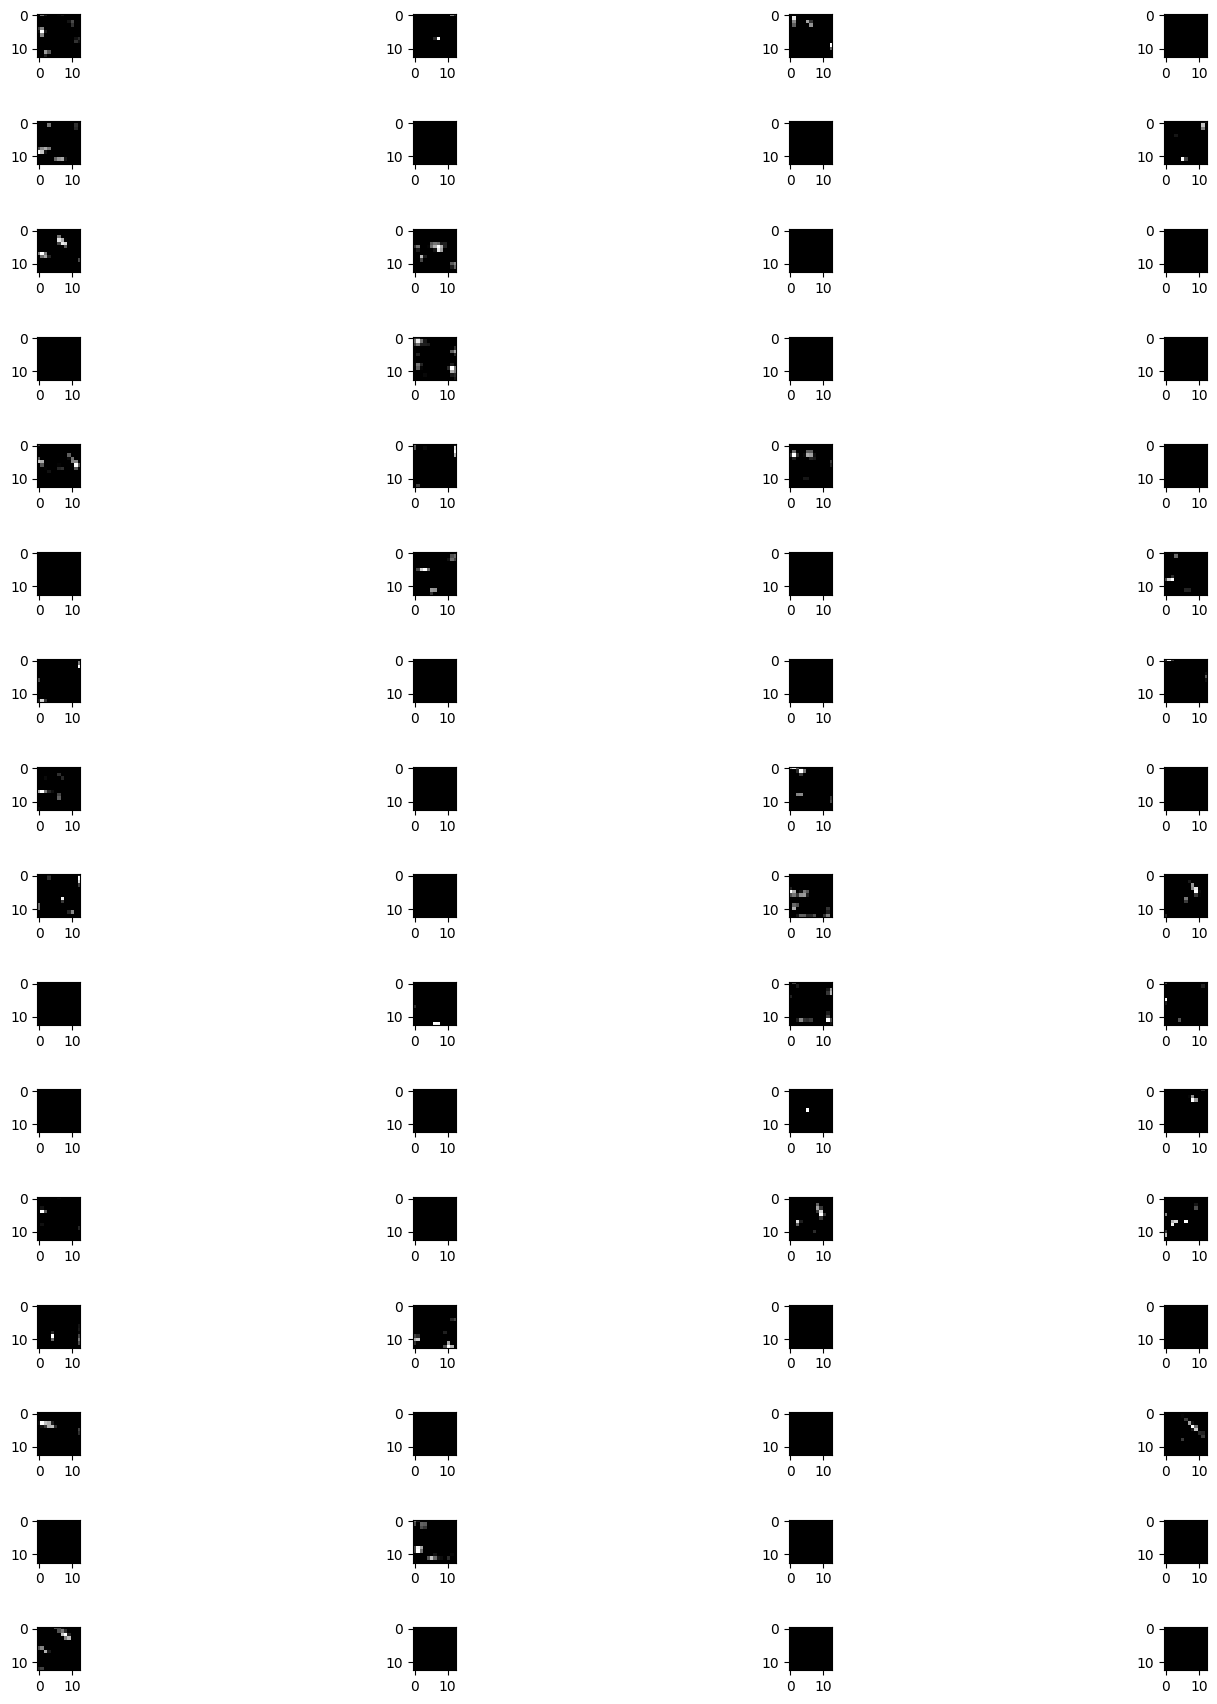

In [157]:
visualData(dataVisual[4][0])

Avg

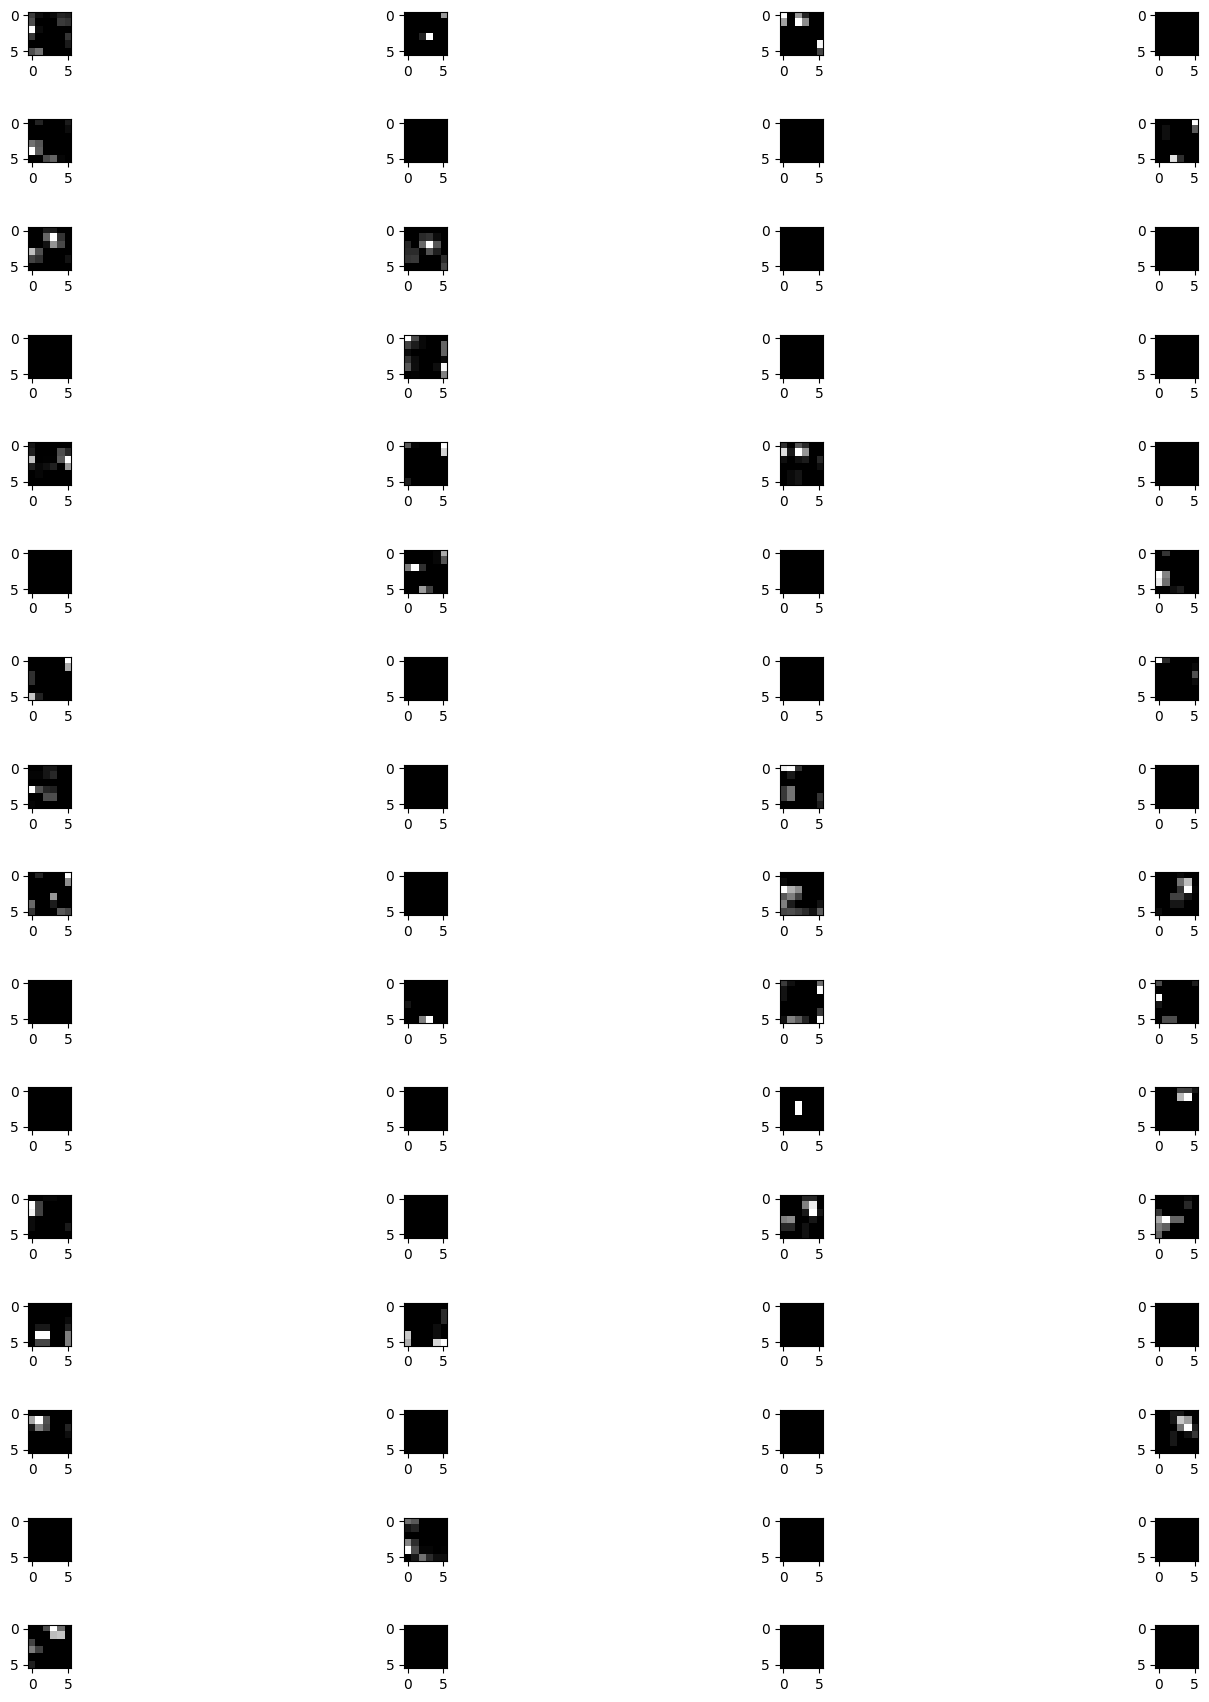

In [158]:
visualData(dataVisual[5][0])